In [1]:
import os
import shutil
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense
from tensorflow.keras import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = '/kaggle/input/studentengagement/Student-engagement-dataset'
target_path = '/kaggle/working/Student-engagement-Dataset'
train_dir = os.path.join(target_path, 'train')
test_dir = os.path.join(target_path, 'test')
valid_dir = os.path.join(target_path, 'validation')

os.makedirs(target_path,exist_ok=True)
os.makedirs(train_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)
os.makedirs(valid_dir,exist_ok=True)

In [4]:
img_size = (256, 256)
for path_ in os.listdir(data_path):
    main_class_dir = os.path.join(data_path, path_)
    for subclass_name in os.listdir(main_class_dir):
        subclass_dir = os.path.join(main_class_dir, subclass_name)

        img_count = len(os.listdir(subclass_dir))                              
        test_img_count = int(0.2*img_count)                                    
        train_img_count = img_count - test_img_count                           


        target_train_class_dir = os.path.join(train_dir, subclass_name)        
        target_test_class_dir = os.path.join(test_dir, subclass_name)     
        target_valid_class_dir = os.path.join(valid_dir, subclass_name)    

        os.makedirs(target_train_class_dir,exist_ok=True)                      
        os.makedirs(target_test_class_dir,exist_ok=True)                       
        os.makedirs(target_valid_class_dir,exist_ok=True)                      

        for file_name in os.listdir(subclass_dir):
            img = cv2.imread(os.path.join(subclass_dir, file_name))
            img = cv2.resize(img, img_size)                                    # Resize image to 224 x 224
            img = img / 255.0                                                  # Normalize pixel values to [0, 1]

            if len(os.listdir(target_test_class_dir)) != test_img_count:
                cv2.imwrite(os.path.join(target_test_class_dir, file_name), img)
            else:
                cv2.imwrite(os.path.join(target_train_class_dir, file_name), img)

> # Split Train into train and validation

In [5]:
for class_folder in os.listdir(train_dir):
    train_class_dir = os.path.join(train_dir, class_folder)
    valid_class_dir = os.path.join(valid_dir, class_folder)
    
    train_ = os.path.join(target_path,'Train')
    os.makedirs(train_,exist_ok=True)
    new_class_dir = os.path.join(train_,class_folder)
    os.makedirs(new_class_dir,exist_ok=True)
    
    img_count =  len(os.listdir(train_class_dir))                           # Get images coount in each class 
    valid_img_count = int(0.2*img_count)                                    # Number of validation images
    train_img_count = img_count - valid_img_count                           # Number of train images
    
    for file_name in os.listdir(train_class_dir):
        img = cv2.imread(os.path.join(train_class_dir, file_name))
        if len(os.listdir(valid_class_dir)) != valid_img_count:
            cv2.imwrite(os.path.join(valid_class_dir, file_name), img)
        else:
            cv2.imwrite(os.path.join(new_class_dir, file_name), img)
            
shutil.rmtree(train_dir)
train_dir = train_

In [6]:
batch_size = 32
img_size = (256, 256,3)

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)


val_generator = val_datagen.flow_from_directory(
        valid_dir,
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        class_mode = 'categorical',
        shuffle=True)

print(train_generator.class_indices)

Found 1699 images belonging to 6 classes.
Found 421 images belonging to 6 classes.
Found 421 images belonging to 6 classes.
{'Looking Away': 0, 'bored': 1, 'confused': 2, 'drowsy': 3, 'engaged': 4, 'frustrated': 5}


> # Build Resnet50 Model 

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (1,1), activation='relu', input_shape=img_size),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(64, (1,1), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'), 
    keras.layers.MaxPooling2D(3,3),    
    keras.layers.Conv2D(128, (1,1), activation='relu'),
     keras.layers.Conv2D(128, (5,5), activation='relu'),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(256, (1,1), activation='relu'),
     keras.layers.Conv2D(256, (5,5), activation='relu'),
    keras.layers.Flatten(), 
    keras.layers.Dense(512, activation='relu'), 
    keras.layers.Dense(6, activation='softmax')  
])
model.summary()

model.compile(optimizer=Adam() ,loss="categorical_crossentropy", metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        2112      
                                                                 
 conv2d_2 (Conv2D)           (None, 83, 83, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 128)       8

In [8]:
checkpoint = ModelCheckpoint("Student Engagement Model.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=9, verbose=1, mode='auto')


history = model.fit(train_generator, validation_data= val_generator,
                           epochs=30,callbacks=[checkpoint,early_stopping])

Epoch 1/30
54/54 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.7769
Epoch 1: val_accuracy improved from -inf to 0.90736, saving model to Student Engagement Model.h5
54/54 [==============================] - 14s 73ms/step - loss: 0.5492 - accuracy: 0.7769 - val_loss: 0.1480 - val_accuracy: 0.9074
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9411
Epoch 2: val_accuracy improved from 0.90736 to 0.94774, saving model to Student Engagement Model.h5
54/54 [==============================] - 3s 55ms/step - loss: 0.1283 - accuracy: 0.9411 - val_loss: 0.1016 - val_accuracy: 0.9477
Epoch 3/30
54/54 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9494
Epoch 3: val_accuracy improved from 0.94774 to 0.95962, saving model to Student Engagement Model.h5
54/54 [==============================] - 3s 62ms/step - loss: 0.0983 - accuracy: 0.9494 - val_loss: 0.0824 - val_accuracy: 0.9596
Epoch 4/30
54/54 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9623
Epoch 4: val_accuracy did not improve from 0.95962
54/54 [==============================] - 4s 67ms/step - loss: 0.0781 - accuracy: 0.9623 - val_loss: 0.0761 - val_accuracy: 0.9596
Epoch 5/30
54/54 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

14/14 [==============================] - 1s 38ms/step - loss: 0.0366 - accuracy: 0.9786
Test Loss: 0.0366
Test Accuracy: 0.9786


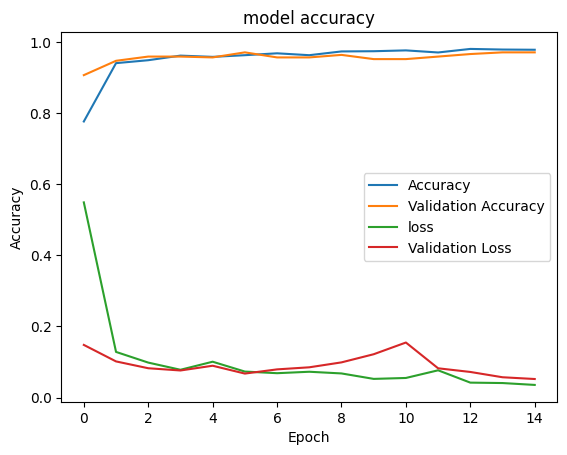

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

1/1 [==============================] - 0s 18ms/step


array([[0., 0., 0., 1., 0., 0.]], dtype=float32)

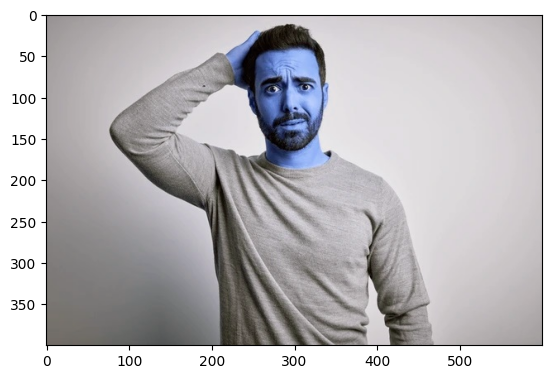

In [14]:
test_img=cv2.imread('/kaggle/input/confus/young-handsome-man-beard-wearing-600nw-1680559948.jpg')
plt.imshow(test_img)
test_img=cv2.resize(test_img,(256,256))
test_inp=test_img.reshape((1,256,256,3))
pred=model.predict(test_inp)
#imageis(pred)
pred

In [24]:
if (pred[0][0]==1):
    print('confused')
elif pred[0][1]==1:
    print('Looking Away')
elif pred[0][2]==1:
    print('bored')
elif pred[0][3]==1:
    print('drowsy')
elif pred[0][4]==1:
    print('engaged')
elif pred[0][5]==1:
    print('Not Interested')
#type(pred)

drowsy


In [26]:
model.save('student_engagement.h5')